# Transfer QAOA params between graphs


In [1]:
import qtensor
import networkx as nx
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

In [11]:
p = 8
gamma, beta = np.linspace(0, 1, p), np.linspace(1, 0, p)
gamma /= 2
beta /= 2

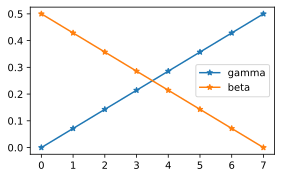

In [12]:
def plot_gamma_beta(gamma, beta):
    plt.plot(gamma,'*-',  label='gamma')
    plt.plot(beta, '*-', label='beta')
    plt.legend()
    
plot_gamma_beta(gamma, beta)

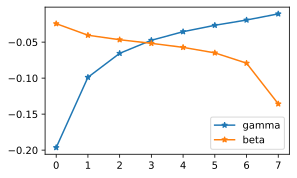

In [13]:
import json
parameters_nu3 = json.load(open('../parameters_nu3.json'))
def get_parameters_nu3(p):
    """
    Args:
        p(int)
    Returns:
        gamma, beta from 0 to 1
    """
    p_ =  parameters_nu3[str(p)]
    return np.array(p_['gamma'])/np.pi, np.array(p_['beta'])/np.pi

gamma, beta = get_parameters_nu3(p)
plot_gamma_beta(gamma, beta)

## Opitimize bethe lattice

In [14]:
B = qtensor.toolbox.bethe_graph(p=p, degree=3)

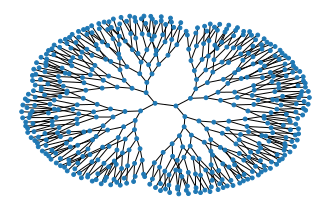

In [8]:
nx.draw_kamada_kawai(B, node_size=15)

In [15]:
from qtensor import parameter_optimization as popt
import torch

In [16]:
loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                      ordering_algo='tamaki_120',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.Adam,
                                                      opt_kwargs=dict(lr=0.006),
                                                      steps=40)

Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=3303, width=1619
Time=3303, width=1619
Time=4132, width=22
Time=4132, width=22
Time=4132, width=22
Time=4132, width=22
Time=5758, width=21
Time=5758, width=21
Time=5758, width=21
Time=7254, width=20
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, width=19
Time=7439, w

Treewidth 17


/home/danlkv/.local/bin/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Best solution: -0.5459816954464144
Best params: [array([-0.17475039, -0.1007334 , -0.06773233, -0.04768992, -0.02150757,
       -0.00468485, -0.00360112, -0.02171446]), array([ 0.04766096, -0.03199901, -0.02148879, -0.03702383, -0.05442378,
       -0.0621934 , -0.07282818, -0.12103661])]


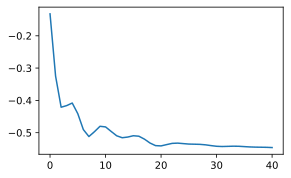

In [17]:
plt.plot(loss_history)
print('Best solution:', np.min(loss_history))
best_ix = np.argmin(loss_history)
best_params = params_history[best_ix]
print('Best params:', best_params)

In [18]:
estimate_cut = 1/2*(B.number_of_edges() - loss_history[best_ix]*B.number_of_edges())
approx_ratio = estimate_cut/B.number_of_edges()
print('Approx ratio:', approx_ratio)

Approx ratio: 0.7729908477232073


## Use multistart

In [23]:
from functools import partial

def optimize_params(gamma, beta, steps=100):
    loss_history, params_history = popt.qaoa_maxcut_torch(
        B, gamma, beta,
        ordering_algo='tamaki_120',
        edge=(0, 1),
        Opt=torch.optim.Adam,
        opt_kwargs=dict(lr=0.005),
        steps=steps
    )
    best_ix = np.argmin(loss_history)
    best_params = params_history[best_ix]
    best_loss = loss_history[best_ix]
    return best_loss, best_params


In [24]:
from cartesian_explorer.parallels import JobLib

parallel = JobLib(processes=112//2)

In [25]:
N = 112
gamma, beta = np.random.randn(N, p), np.random.randn(N, p)
pargs = zip(gamma, beta)

In [26]:
best_loss_params = parallel.starmap(partial(optimize_params, steps=300), pargs)

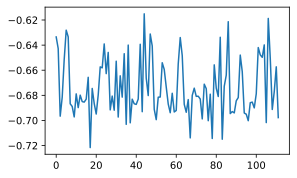

In [27]:
best_loss, best_params = zip(*best_loss_params)
plt.plot(best_loss)

In [28]:
best_best_loss = np.min(best_loss)
best_best_index = np.argmin(best_loss)
approx_ratio = 1/2*(1-best_best_loss)
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8608100430573644


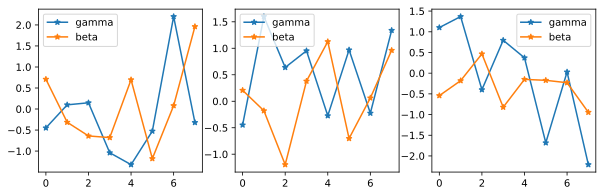

In [29]:
loss_params_sorted = sorted(best_loss_params, key=lambda x: x[0])
plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_gamma_beta(*loss_params_sorted[0][1])
plt.subplot(132)
plot_gamma_beta(*loss_params_sorted[1][1])
plt.subplot(133)
plot_gamma_beta(*loss_params_sorted[2][1])

## Re-start learning

In [31]:
leave_out_num = 20
N = 112 - leave_out_num
leave_out_params = list(list(zip(*loss_params_sorted))[1])[:leave_out_num]  
next_params = leave_out_params + list(zip(np.random.randn(N, p), np.random.randn(N, p)))

In [ ]:
next_best_loss_params = parallel.starmap(partial(optimize_params, steps=300), next_params)

Approx ratio: 0.8583794193462353


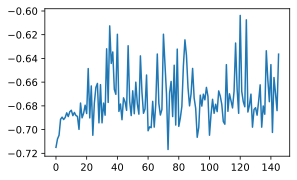

In [98]:
best_loss, best_params = zip(*next_best_loss_params)
plt.plot(best_loss)
best_best_loss = np.min(best_loss)
best_best_index = np.argmin(best_loss)
approx_ratio = 1/2*(1-best_best_loss)
print('Approx ratio:', approx_ratio)

In [99]:
best_loss_params = next_best_loss_params

### Finish up by further optimizing the best point

In [100]:
gamma, beta = best_params[best_best_index]

In [101]:
gamma, beta

(array([ 0.45032692, -1.59767389, -0.10992576,  1.37776669, -0.68170367,
        -0.97164854,  0.78962364]),
 array([-0.70481029,  1.67401291,  1.15593685,  1.85465617,  0.32534419,
         0.27089758,  0.05440007]))

In [90]:
loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                      ordering_algo='tamaki_40',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.Adam,
                                                      opt_kwargs=dict(lr=0.0002),
                                                      steps=20)

Best solution: -0.7149610829891299
Best params: [array([-0.58576837,  1.05404401, -0.64719785, -1.62089253, -0.13675797,
       -0.16263004,  1.31963884]), array([ 0.12868154,  0.13226227, -1.32794239, -0.64621956,  1.38890427,
        0.42095737, -0.95688474])]


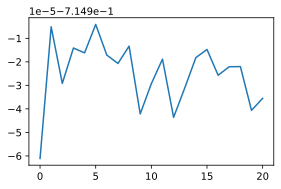

In [91]:
plt.plot(loss_history)
print('Best solution:', np.min(loss_history))
best_ix = np.argmin(loss_history)
best_params = params_history[best_ix]
print('Best params:', best_params)

In [87]:
estimate_cut = 1/2*(B.number_of_edges() - loss_history[best_ix]*B.number_of_edges())
approx_ratio = estimate_cut/B.number_of_edges()
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8574805414945649


## Check the same parameters for random regular graph

Number of edges: 15


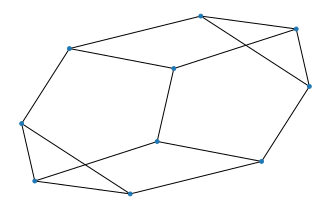

In [17]:
G = qtensor.toolbox.random_graph(nodes=10, degree=3, seed=10)
print('Number of edges:', G.number_of_edges())
nx.draw_kamada_kawai(G, node_size=15)

In [18]:
def maxcut_cost(G, gamma, beta):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer)
    return sim.energy_expectation(G, gamma, beta)

In [19]:
maxcut_cost(G, *best_params)

array([12.33029447])

In [20]:
loss_history, param_history = popt.qaoa_maxcut_torch(G, gamma, beta, steps=20)

KeyboardInterrupt: 

Best energy: 20.805624


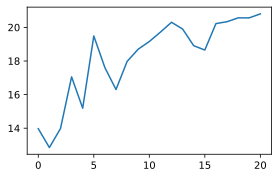

In [15]:
energies = - np.array(loss_history)
print('Best energy:', np.max(energies))
plt.plot(energies)

In [24]:
bound = qtensor.tools.maxcut.spectral_bound(G)
transfer_cost = maxcut_cost(G, *best_params)[0]
approx_ratio_bound = transfer_cost/(bound*G.number_of_edges())
print("Approx ratio bound =", approx_ratio_bound)
print("Approx ratio Bethe =", approx_ratio)


Approx ratio bound = 0.9039485906264829
Approx ratio Bethe = 0.8433088647040107


In [25]:
transfer_cost

12.330294472795362

In [31]:
transfer_cost/(bound*G.number_of_edges())

0.9039485906264829

## Compare for multiple graphs

In [21]:
from cartesian_explorer import Explorer
ex = Explorer()

In [22]:
@ex.provider
def graph(N, seed=10):
    return nx.random_regular_graph(d=3, n=N, seed=seed)

In [23]:
@ex.provider
def regular_approximation_bound(graph, p, bethe_params):
    gamma, beta = bethe_params
    bound = qtensor.tools.maxcut.spectral_bound(graph)
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, max_tw=25)
    try:
        transfer_cost = sim.energy_expectation(graph, gamma, beta)
    except Exception as e:
        print(e)
        return None
    approx_ratio_bound = transfer_cost/(bound*graph.number_of_edges())
    return approx_ratio_bound


In [24]:

@ex.provider
def bethe_approximation_cache(p):
    return qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']

@ex.provider
def bethe_params_cache(p):
    gammabeta = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'] 
    gammabeta = np.array(gammabeta)
    gammabeta = gammabeta/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    assert len(beta)==len(gamma), "Wrong parameters format, possibly unsolved p"
    return tuple(beta), tuple(gamma)
    

In [25]:
@ex.add_function(provides=('bethe_approximation', 'bethe_params'), requires=('p'))
def bethe_params(p, seed=10):
    B = qtensor.toolbox.bethe_graph(p=p, degree=3)
    gamma, beta = 1-np.cos(np.linspace(0,1,p)), 1-np.cos(np.linspace(0,1,p))
    loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                          edge=(0, 1),
                                                          Opt=torch.optim.Adam,
                                                          opt_kwargs=dict(lr=0.006),
                                                          steps=200)
    best_ix = np.argmin(loss_history)
    best_loss = loss_history[best_ix]
    best_params = params_history[best_ix]
    estimate_cut = 1/2*(1 - best_loss)
    approx_ratio = estimate_cut
    return approx_ratio, (tuple(best_params[0]), tuple(best_params[1]))


Treewidth 26 is larger than max_tw=25.



Treewidth 26 is larger than max_tw=25.



Treewidth 27 is larger than max_tw=25.



Treewidth 29 is larger than max_tw=25.



Treewidth 31 is larger than max_tw=25.



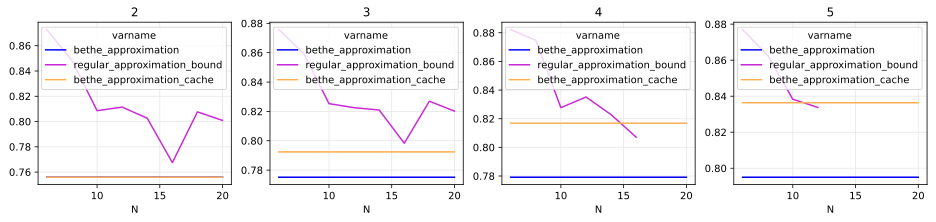

In [155]:
f = ex.plot2d(ex.get_variable,
          p=[2,3,4,5],
          varname=('bethe_approximation', 'regular_approximation_bound', 'bethe_approximation_cache'),
          N=range(6, 22, 2),
          seed=[10]
         )
plt.savefig('/tmp/plot_approx.png')

In [154]:
p = 3
gb = bethe_params_cache(p)
gamma, beta = gb
gamma, beta

((0.14625538825784332, 0.35087973860935995, 0.42500476233846124),
 (0.932857136289293, 0.19381151457591544, -0.12706819386164936))

In [153]:
maxcut_cost(G, -np.array(beta), -np.array(gamma))

array([7.0612915])

In [124]:
G.number_of_edges

15

In [26]:
bethe_approximation_cache(5)

0.8363793482380077

In [32]:
bethe_approximation_cache(6)

0.8498938819897202